In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_b25_targets_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(684288, 1380)
(684288, 1)
validation
(113488, 1380)
(113488, 1)
test
(56512, 1380)
(56512, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1380)]            0         


 dense (Dense)               (None, 1024)              1414144   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2103297 (8.02 MB)


Trainable params: 2103297 (8.02 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/69 [..............................] - ETA: 1:42 - loss: 0.1987 - STD: 1.5070e-04 - MAE: 0.4331

 3/69 [>.............................] - ETA: 2s - loss: 0.0836 - STD: 5.4200e-04 - MAE: 0.2328  

 5/69 [=>............................] - ETA: 2s - loss: 0.0588 - STD: 4.3558e-04 - MAE: 0.1841

 7/69 [==>...........................] - ETA: 9s - loss: 0.0526 - STD: 3.3535e-04 - MAE: 0.1731

 9/69 [==>...........................] - ETA: 7s - loss: 0.0484 - STD: 2.6716e-04 - MAE: 0.1691

11/69 [===>..........................] - ETA: 5s - loss: 0.0459 - STD: 2.1972e-04 - MAE: 0.1670

13/69 [====>.........................] - ETA: 5s - loss: 0.0441 - STD: 1.8821e-04 - MAE: 0.1651

15/69 [=====>........................] - ETA: 4s - loss: 0.0424 - STD: 1.6717e-04 - MAE: 0.1625

17/69 [======>.......................] - ETA: 3s - loss: 0.0406 - STD: 1.5294e-04 - MAE: 0.1589

19/69 [=======>......................] - ETA: 3s - loss: 0.0387 - STD: 1.4346e-04 - MAE: 0.1543

21/69 [========>.....................] - ETA: 3s - loss: 0.0366 - STD: 1.3732e-04 - MAE: 0.1486

23/69 [=========>....................] - ETA: 2s - loss: 0.0344 - STD: 1.3341e-04 - MAE: 0.1428

25/69 [=========>....................] - ETA: 2s - loss: 0.0325 - STD: 1.3083e-04 - MAE: 0.1380

27/69 [==========>...................] - ETA: 2s - loss: 0.0311 - STD: 1.2871e-04 - MAE: 0.1350

29/69 [===========>..................] - ETA: 2s - loss: 0.0299 - STD: 1.2637e-04 - MAE: 0.1330

31/69 [============>.................] - ETA: 2s - loss: 0.0289 - STD: 1.2354e-04 - MAE: 0.1311

33/69 [=============>................] - ETA: 1s - loss: 0.0279 - STD: 1.1998e-04 - MAE: 0.1288

35/69 [==============>...............] - ETA: 1s - loss: 0.0269 - STD: 1.1591e-04 - MAE: 0.1263

37/69 [===============>..............] - ETA: 1s - loss: 0.0261 - STD: 1.1165e-04 - MAE: 0.1238

39/69 [===============>..............] - ETA: 1s - loss: 0.0253 - STD: 1.0746e-04 - MAE: 0.1216

41/69 [================>.............] - ETA: 1s - loss: 0.0246 - STD: 1.0350e-04 - MAE: 0.1195

43/69 [=================>............] - ETA: 1s - loss: 0.0241 - STD: 9.9849e-05 - MAE: 0.1177

45/69 [==================>...........] - ETA: 1s - loss: 0.0235 - STD: 9.6546e-05 - MAE: 0.1160

47/69 [===================>..........] - ETA: 1s - loss: 0.0230 - STD: 9.3591e-05 - MAE: 0.1145

49/69 [====================>.........] - ETA: 0s - loss: 0.0225 - STD: 9.0953e-05 - MAE: 0.1132

51/69 [=====================>........] - ETA: 0s - loss: 0.0220 - STD: 8.8589e-05 - MAE: 0.1120

53/69 [======================>.......] - ETA: 0s - loss: 0.0216 - STD: 8.6436e-05 - MAE: 0.1111

55/69 [======================>.......] - ETA: 0s - loss: 0.0212 - STD: 8.4433e-05 - MAE: 0.1102

57/69 [=======================>......] - ETA: 0s - loss: 0.0209 - STD: 8.2537e-05 - MAE: 0.1093

59/69 [========================>.....] - ETA: 0s - loss: 0.0205 - STD: 8.0724e-05 - MAE: 0.1084

61/69 [=========================>....] - ETA: 0s - loss: 0.0202 - STD: 7.8983e-05 - MAE: 0.1076

63/69 [==========================>...] - ETA: 0s - loss: 0.0199 - STD: 7.7319e-05 - MAE: 0.1067

65/69 [===========================>..] - ETA: 0s - loss: 0.0196 - STD: 7.5735e-05 - MAE: 0.1059

67/69 [============================>.] - ETA: 0s - loss: 0.0194 - STD: 7.4247e-05 - MAE: 0.1052

69/69 [==============================] - ETA: 0s - loss: 0.0191 - STD: 7.2852e-05 - MAE: 0.1044

69/69 [==============================] - 5s 56ms/step - loss: 0.0191 - STD: 7.2852e-05 - MAE: 0.1044 - val_loss: 0.0128 - val_STD: 8.2253e-06 - val_MAE: 0.0859


Epoch 2/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0107 - STD: 2.6838e-05 - MAE: 0.0801

 3/69 [>.............................] - ETA: 2s - loss: 0.0107 - STD: 2.7170e-05 - MAE: 0.0807

 5/69 [=>............................] - ETA: 2s - loss: 0.0108 - STD: 2.7479e-05 - MAE: 0.0815

 7/69 [==>...........................] - ETA: 1s - loss: 0.0109 - STD: 2.7765e-05 - MAE: 0.0818

 9/69 [==>...........................] - ETA: 1s - loss: 0.0109 - STD: 2.7982e-05 - MAE: 0.0819

11/69 [===>..........................] - ETA: 1s - loss: 0.0109 - STD: 2.8074e-05 - MAE: 0.0822

13/69 [====>.........................] - ETA: 1s - loss: 0.0109 - STD: 2.8145e-05 - MAE: 0.0821

15/69 [=====>........................] - ETA: 1s - loss: 0.0109 - STD: 2.8180e-05 - MAE: 0.0822

17/69 [======>.......................] - ETA: 1s - loss: 0.0109 - STD: 2.8171e-05 - MAE: 0.0822

19/69 [=======>......................] - ETA: 1s - loss: 0.0109 - STD: 2.8147e-05 - MAE: 0.0821

21/69 [========>.....................] - ETA: 1s - loss: 0.0109 - STD: 2.8165e-05 - MAE: 0.0821

23/69 [=========>....................] - ETA: 1s - loss: 0.0109 - STD: 2.8215e-05 - MAE: 0.0820

25/69 [=========>....................] - ETA: 1s - loss: 0.0109 - STD: 2.8265e-05 - MAE: 0.0820

27/69 [==========>...................] - ETA: 1s - loss: 0.0109 - STD: 2.8349e-05 - MAE: 0.0820

29/69 [===========>..................] - ETA: 1s - loss: 0.0109 - STD: 2.8454e-05 - MAE: 0.0820

31/69 [============>.................] - ETA: 1s - loss: 0.0109 - STD: 2.8539e-05 - MAE: 0.0820

33/69 [=============>................] - ETA: 1s - loss: 0.0109 - STD: 2.8647e-05 - MAE: 0.0820

35/69 [==============>...............] - ETA: 1s - loss: 0.0109 - STD: 2.8747e-05 - MAE: 0.0820

37/69 [===============>..............] - ETA: 1s - loss: 0.0109 - STD: 2.8829e-05 - MAE: 0.0820

39/69 [===============>..............] - ETA: 0s - loss: 0.0109 - STD: 2.8913e-05 - MAE: 0.0821

42/69 [=================>............] - ETA: 0s - loss: 0.0109 - STD: 2.9014e-05 - MAE: 0.0820

44/69 [==================>...........] - ETA: 0s - loss: 0.0109 - STD: 2.9101e-05 - MAE: 0.0820

46/69 [===================>..........] - ETA: 0s - loss: 0.0109 - STD: 2.9201e-05 - MAE: 0.0820

48/69 [===================>..........] - ETA: 0s - loss: 0.0109 - STD: 2.9299e-05 - MAE: 0.0820

50/69 [====================>.........] - ETA: 0s - loss: 0.0109 - STD: 2.9405e-05 - MAE: 0.0820

52/69 [=====================>........] - ETA: 0s - loss: 0.0109 - STD: 2.9506e-05 - MAE: 0.0820

54/69 [======================>.......] - ETA: 0s - loss: 0.0109 - STD: 2.9621e-05 - MAE: 0.0820

56/69 [=======================>......] - ETA: 0s - loss: 0.0109 - STD: 2.9742e-05 - MAE: 0.0820

58/69 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 2.9855e-05 - MAE: 0.0820

60/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 2.9987e-05 - MAE: 0.0820

62/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 3.0101e-05 - MAE: 0.0820

64/69 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 3.0218e-05 - MAE: 0.0820

66/69 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 3.0345e-05 - MAE: 0.0820

68/69 [============================>.] - ETA: 0s - loss: 0.0110 - STD: 3.0465e-05 - MAE: 0.0820

69/69 [==============================] - 3s 38ms/step - loss: 0.0109 - STD: 3.0524e-05 - MAE: 0.0820 - val_loss: 0.0127 - val_STD: 1.5196e-05 - val_MAE: 0.0861


Epoch 3/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0109 - STD: 3.5142e-05 - MAE: 0.0817

 3/69 [>.............................] - ETA: 2s - loss: 0.0109 - STD: 3.5247e-05 - MAE: 0.0820

 5/69 [=>............................] - ETA: 2s - loss: 0.0109 - STD: 3.5532e-05 - MAE: 0.0821

 7/69 [==>...........................] - ETA: 2s - loss: 0.0110 - STD: 3.5673e-05 - MAE: 0.0821

10/69 [===>..........................] - ETA: 1s - loss: 0.0110 - STD: 3.5977e-05 - MAE: 0.0821

12/69 [====>.........................] - ETA: 1s - loss: 0.0110 - STD: 3.6235e-05 - MAE: 0.0821

14/69 [=====>........................] - ETA: 1s - loss: 0.0110 - STD: 3.6434e-05 - MAE: 0.0821

16/69 [=====>........................] - ETA: 1s - loss: 0.0109 - STD: 3.6602e-05 - MAE: 0.0821

18/69 [======>.......................] - ETA: 1s - loss: 0.0110 - STD: 3.6784e-05 - MAE: 0.0821

20/69 [=======>......................] - ETA: 1s - loss: 0.0110 - STD: 3.6987e-05 - MAE: 0.0821

22/69 [========>.....................] - ETA: 1s - loss: 0.0109 - STD: 3.7141e-05 - MAE: 0.0820

24/69 [=========>....................] - ETA: 1s - loss: 0.0109 - STD: 3.7336e-05 - MAE: 0.0820

26/69 [==========>...................] - ETA: 1s - loss: 0.0109 - STD: 3.7552e-05 - MAE: 0.0819

28/69 [===========>..................] - ETA: 1s - loss: 0.0109 - STD: 3.7754e-05 - MAE: 0.0819

30/69 [============>.................] - ETA: 1s - loss: 0.0109 - STD: 3.7965e-05 - MAE: 0.0819

32/69 [============>.................] - ETA: 1s - loss: 0.0109 - STD: 3.8207e-05 - MAE: 0.0819

34/69 [=============>................] - ETA: 1s - loss: 0.0109 - STD: 3.8423e-05 - MAE: 0.0819

36/69 [==============>...............] - ETA: 1s - loss: 0.0109 - STD: 3.8665e-05 - MAE: 0.0820

38/69 [===============>..............] - ETA: 0s - loss: 0.0109 - STD: 3.8926e-05 - MAE: 0.0820

40/69 [================>.............] - ETA: 0s - loss: 0.0109 - STD: 3.9169e-05 - MAE: 0.0820

42/69 [=================>............] - ETA: 0s - loss: 0.0110 - STD: 3.9427e-05 - MAE: 0.0820

44/69 [==================>...........] - ETA: 0s - loss: 0.0109 - STD: 3.9675e-05 - MAE: 0.0820

46/69 [===================>..........] - ETA: 0s - loss: 0.0109 - STD: 3.9933e-05 - MAE: 0.0820

48/69 [===================>..........] - ETA: 0s - loss: 0.0109 - STD: 4.0197e-05 - MAE: 0.0820

50/69 [====================>.........] - ETA: 0s - loss: 0.0109 - STD: 4.0456e-05 - MAE: 0.0820

52/69 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 4.0720e-05 - MAE: 0.0820

54/69 [======================>.......] - ETA: 0s - loss: 0.0110 - STD: 4.0996e-05 - MAE: 0.0820

56/69 [=======================>......] - ETA: 0s - loss: 0.0109 - STD: 4.1274e-05 - MAE: 0.0820

58/69 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 4.1565e-05 - MAE: 0.0820

60/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 4.1874e-05 - MAE: 0.0820

62/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 4.2172e-05 - MAE: 0.0820

64/69 [==========================>...] - ETA: 0s - loss: 0.0109 - STD: 4.2471e-05 - MAE: 0.0820

66/69 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 4.2785e-05 - MAE: 0.0820

68/69 [============================>.] - ETA: 0s - loss: 0.0109 - STD: 4.3112e-05 - MAE: 0.0820

69/69 [==============================] - 3s 37ms/step - loss: 0.0109 - STD: 4.3275e-05 - MAE: 0.0820 - val_loss: 0.0127 - val_STD: 2.9704e-05 - val_MAE: 0.0862


Epoch 4/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0111 - STD: 5.4699e-05 - MAE: 0.0827

 3/69 [>.............................] - ETA: 2s - loss: 0.0109 - STD: 5.5788e-05 - MAE: 0.0819

 5/69 [=>............................] - ETA: 2s - loss: 0.0109 - STD: 5.6002e-05 - MAE: 0.0819

 7/69 [==>...........................] - ETA: 2s - loss: 0.0110 - STD: 5.6397e-05 - MAE: 0.0821

 9/69 [==>...........................] - ETA: 1s - loss: 0.0110 - STD: 5.6833e-05 - MAE: 0.0822

11/69 [===>..........................] - ETA: 1s - loss: 0.0110 - STD: 5.7214e-05 - MAE: 0.0822

13/69 [====>.........................] - ETA: 1s - loss: 0.0110 - STD: 5.7710e-05 - MAE: 0.0822

15/69 [=====>........................] - ETA: 1s - loss: 0.0110 - STD: 5.8225e-05 - MAE: 0.0821

17/69 [======>.......................] - ETA: 1s - loss: 0.0110 - STD: 5.8755e-05 - MAE: 0.0822

19/69 [=======>......................] - ETA: 1s - loss: 0.0110 - STD: 5.9250e-05 - MAE: 0.0822

21/69 [========>.....................] - ETA: 1s - loss: 0.0110 - STD: 5.9757e-05 - MAE: 0.0820

23/69 [=========>....................] - ETA: 1s - loss: 0.0109 - STD: 6.0280e-05 - MAE: 0.0819

25/69 [=========>....................] - ETA: 1s - loss: 0.0109 - STD: 6.0860e-05 - MAE: 0.0819

27/69 [==========>...................] - ETA: 1s - loss: 0.0109 - STD: 6.1435e-05 - MAE: 0.0818

29/69 [===========>..................] - ETA: 1s - loss: 0.0109 - STD: 6.2054e-05 - MAE: 0.0819

32/69 [============>.................] - ETA: 1s - loss: 0.0109 - STD: 6.3010e-05 - MAE: 0.0818

34/69 [=============>................] - ETA: 1s - loss: 0.0109 - STD: 6.3677e-05 - MAE: 0.0818

36/69 [==============>...............] - ETA: 1s - loss: 0.0109 - STD: 6.4317e-05 - MAE: 0.0818

38/69 [===============>..............] - ETA: 0s - loss: 0.0109 - STD: 6.4939e-05 - MAE: 0.0818

40/69 [================>.............] - ETA: 0s - loss: 0.0109 - STD: 6.5586e-05 - MAE: 0.0818

42/69 [=================>............] - ETA: 0s - loss: 0.0109 - STD: 6.6279e-05 - MAE: 0.0818

44/69 [==================>...........] - ETA: 0s - loss: 0.0109 - STD: 6.7028e-05 - MAE: 0.0818

46/69 [===================>..........] - ETA: 0s - loss: 0.0109 - STD: 6.7787e-05 - MAE: 0.0818

48/69 [===================>..........] - ETA: 0s - loss: 0.0109 - STD: 6.8540e-05 - MAE: 0.0818

50/69 [====================>.........] - ETA: 0s - loss: 0.0109 - STD: 6.9332e-05 - MAE: 0.0819

52/69 [=====================>........] - ETA: 0s - loss: 0.0109 - STD: 7.0162e-05 - MAE: 0.0819

54/69 [======================>.......] - ETA: 0s - loss: 0.0109 - STD: 7.1020e-05 - MAE: 0.0819

56/69 [=======================>......] - ETA: 0s - loss: 0.0109 - STD: 7.1857e-05 - MAE: 0.0819

58/69 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 7.2742e-05 - MAE: 0.0819

60/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 7.3623e-05 - MAE: 0.0819

62/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 7.4522e-05 - MAE: 0.0819

64/69 [==========================>...] - ETA: 0s - loss: 0.0109 - STD: 7.5476e-05 - MAE: 0.0819

66/69 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 7.6500e-05 - MAE: 0.0819

68/69 [============================>.] - ETA: 0s - loss: 0.0109 - STD: 7.7523e-05 - MAE: 0.0819

69/69 [==============================] - 3s 38ms/step - loss: 0.0109 - STD: 7.8039e-05 - MAE: 0.0819 - val_loss: 0.0126 - val_STD: 7.1878e-05 - val_MAE: 0.0863


Epoch 5/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0110 - STD: 1.1595e-04 - MAE: 0.0832

 3/69 [>.............................] - ETA: 2s - loss: 0.0111 - STD: 1.1675e-04 - MAE: 0.0829

 5/69 [=>............................] - ETA: 2s - loss: 0.0109 - STD: 1.1803e-04 - MAE: 0.0823

 7/69 [==>...........................] - ETA: 2s - loss: 0.0110 - STD: 1.1951e-04 - MAE: 0.0822

 9/69 [==>...........................] - ETA: 1s - loss: 0.0110 - STD: 1.2086e-04 - MAE: 0.0821

11/69 [===>..........................] - ETA: 1s - loss: 0.0110 - STD: 1.2255e-04 - MAE: 0.0821

13/69 [====>.........................] - ETA: 1s - loss: 0.0110 - STD: 1.2472e-04 - MAE: 0.0821

15/69 [=====>........................] - ETA: 1s - loss: 0.0110 - STD: 1.2681e-04 - MAE: 0.0822

17/69 [======>.......................] - ETA: 1s - loss: 0.0110 - STD: 1.2897e-04 - MAE: 0.0822

19/69 [=======>......................] - ETA: 1s - loss: 0.0110 - STD: 1.3117e-04 - MAE: 0.0822

22/69 [========>.....................] - ETA: 1s - loss: 0.0110 - STD: 1.3472e-04 - MAE: 0.0822

24/69 [=========>....................] - ETA: 1s - loss: 0.0110 - STD: 1.3707e-04 - MAE: 0.0822

26/69 [==========>...................] - ETA: 1s - loss: 0.0110 - STD: 1.3928e-04 - MAE: 0.0822

28/69 [===========>..................] - ETA: 1s - loss: 0.0110 - STD: 1.4161e-04 - MAE: 0.0822

30/69 [============>.................] - ETA: 1s - loss: 0.0110 - STD: 1.4398e-04 - MAE: 0.0821

32/69 [============>.................] - ETA: 1s - loss: 0.0110 - STD: 1.4664e-04 - MAE: 0.0821

34/69 [=============>................] - ETA: 1s - loss: 0.0110 - STD: 1.4946e-04 - MAE: 0.0821

36/69 [==============>...............] - ETA: 1s - loss: 0.0110 - STD: 1.5239e-04 - MAE: 0.0820

38/69 [===============>..............] - ETA: 0s - loss: 0.0110 - STD: 1.5542e-04 - MAE: 0.0820

40/69 [================>.............] - ETA: 0s - loss: 0.0110 - STD: 1.5860e-04 - MAE: 0.0820

42/69 [=================>............] - ETA: 0s - loss: 0.0109 - STD: 1.6176e-04 - MAE: 0.0820

44/69 [==================>...........] - ETA: 0s - loss: 0.0110 - STD: 1.6510e-04 - MAE: 0.0820

46/69 [===================>..........] - ETA: 0s - loss: 0.0110 - STD: 1.6850e-04 - MAE: 0.0820

48/69 [===================>..........] - ETA: 0s - loss: 0.0109 - STD: 1.7210e-04 - MAE: 0.0820

50/69 [====================>.........] - ETA: 0s - loss: 0.0109 - STD: 1.7595e-04 - MAE: 0.0820

52/69 [=====================>........] - ETA: 0s - loss: 0.0109 - STD: 1.7997e-04 - MAE: 0.0820

54/69 [======================>.......] - ETA: 0s - loss: 0.0109 - STD: 1.8403e-04 - MAE: 0.0820

56/69 [=======================>......] - ETA: 0s - loss: 0.0109 - STD: 1.8824e-04 - MAE: 0.0820

58/69 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 1.9252e-04 - MAE: 0.0819

60/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 1.9712e-04 - MAE: 0.0819

62/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 2.0200e-04 - MAE: 0.0819

64/69 [==========================>...] - ETA: 0s - loss: 0.0109 - STD: 2.0710e-04 - MAE: 0.0819

66/69 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 2.1247e-04 - MAE: 0.0819

68/69 [============================>.] - ETA: 0s - loss: 0.0109 - STD: 2.1795e-04 - MAE: 0.0820

69/69 [==============================] - 3s 37ms/step - loss: 0.0109 - STD: 2.2079e-04 - MAE: 0.0819 - val_loss: 0.0126 - val_STD: 2.9097e-04 - val_MAE: 0.0860


Epoch 6/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0111 - STD: 4.2346e-04 - MAE: 0.0824

 3/69 [>.............................] - ETA: 2s - loss: 0.0109 - STD: 4.3782e-04 - MAE: 0.0820

 5/69 [=>............................] - ETA: 2s - loss: 0.0109 - STD: 4.4961e-04 - MAE: 0.0818

 7/69 [==>...........................] - ETA: 1s - loss: 0.0109 - STD: 4.6218e-04 - MAE: 0.0818

 9/69 [==>...........................] - ETA: 1s - loss: 0.0109 - STD: 4.7427e-04 - MAE: 0.0818

11/69 [===>..........................] - ETA: 1s - loss: 0.0109 - STD: 4.8813e-04 - MAE: 0.0818

13/69 [====>.........................] - ETA: 1s - loss: 0.0109 - STD: 5.0220e-04 - MAE: 0.0819

15/69 [=====>........................] - ETA: 1s - loss: 0.0109 - STD: 5.1741e-04 - MAE: 0.0819

17/69 [======>.......................] - ETA: 1s - loss: 0.0109 - STD: 5.3339e-04 - MAE: 0.0819

19/69 [=======>......................] - ETA: 1s - loss: 0.0109 - STD: 5.5127e-04 - MAE: 0.0820

21/69 [========>.....................] - ETA: 1s - loss: 0.0109 - STD: 5.6896e-04 - MAE: 0.0819

23/69 [=========>....................] - ETA: 1s - loss: 0.0109 - STD: 5.8734e-04 - MAE: 0.0819

25/69 [=========>....................] - ETA: 1s - loss: 0.0109 - STD: 6.0779e-04 - MAE: 0.0819

27/69 [==========>...................] - ETA: 1s - loss: 0.0109 - STD: 6.2928e-04 - MAE: 0.0819

29/69 [===========>..................] - ETA: 1s - loss: 0.0109 - STD: 6.5156e-04 - MAE: 0.0819

31/69 [============>.................] - ETA: 1s - loss: 0.0109 - STD: 6.7578e-04 - MAE: 0.0819

33/69 [=============>................] - ETA: 1s - loss: 0.0109 - STD: 7.0121e-04 - MAE: 0.0818

35/69 [==============>...............] - ETA: 1s - loss: 0.0109 - STD: 7.2736e-04 - MAE: 0.0818

37/69 [===============>..............] - ETA: 1s - loss: 0.0109 - STD: 7.5558e-04 - MAE: 0.0818

40/69 [================>.............] - ETA: 0s - loss: 0.0109 - STD: 8.0145e-04 - MAE: 0.0818

42/69 [=================>............] - ETA: 0s - loss: 0.0109 - STD: 8.3468e-04 - MAE: 0.0818

44/69 [==================>...........] - ETA: 0s - loss: 0.0109 - STD: 8.6990e-04 - MAE: 0.0818

46/69 [===================>..........] - ETA: 0s - loss: 0.0109 - STD: 9.0714e-04 - MAE: 0.0818

48/69 [===================>..........] - ETA: 0s - loss: 0.0109 - STD: 9.4624e-04 - MAE: 0.0818

50/69 [====================>.........] - ETA: 0s - loss: 0.0109 - STD: 9.8804e-04 - MAE: 0.0818

52/69 [=====================>........] - ETA: 0s - loss: 0.0109 - STD: 0.0010 - MAE: 0.0818    

54/69 [======================>.......] - ETA: 0s - loss: 0.0109 - STD: 0.0011 - MAE: 0.0818

56/69 [=======================>......] - ETA: 0s - loss: 0.0109 - STD: 0.0011 - MAE: 0.0817

58/69 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 0.0012 - MAE: 0.0817

60/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 0.0012 - MAE: 0.0817

62/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 0.0013 - MAE: 0.0817

64/69 [==========================>...] - ETA: 0s - loss: 0.0108 - STD: 0.0014 - MAE: 0.0817

66/69 [===========================>..] - ETA: 0s - loss: 0.0108 - STD: 0.0015 - MAE: 0.0817

68/69 [============================>.] - ETA: 0s - loss: 0.0108 - STD: 0.0015 - MAE: 0.0816

69/69 [==============================] - 3s 38ms/step - loss: 0.0108 - STD: 0.0016 - MAE: 0.0816 - val_loss: 0.0122 - val_STD: 0.0034 - val_MAE: 0.0849


Epoch 7/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0105 - STD: 0.0046 - MAE: 0.0806

 3/69 [>.............................] - ETA: 2s - loss: 0.0105 - STD: 0.0048 - MAE: 0.0806

 5/69 [=>............................] - ETA: 2s - loss: 0.0104 - STD: 0.0050 - MAE: 0.0803

 7/69 [==>...........................] - ETA: 2s - loss: 0.0104 - STD: 0.0052 - MAE: 0.0804

 9/69 [==>...........................] - ETA: 1s - loss: 0.0105 - STD: 0.0055 - MAE: 0.0804

11/69 [===>..........................] - ETA: 1s - loss: 0.0105 - STD: 0.0058 - MAE: 0.0805

13/69 [====>.........................] - ETA: 1s - loss: 0.0104 - STD: 0.0061 - MAE: 0.0805

15/69 [=====>........................] - ETA: 1s - loss: 0.0104 - STD: 0.0064 - MAE: 0.0804

17/69 [======>.......................] - ETA: 1s - loss: 0.0104 - STD: 0.0067 - MAE: 0.0803

19/69 [=======>......................] - ETA: 1s - loss: 0.0104 - STD: 0.0070 - MAE: 0.0803

21/69 [========>.....................] - ETA: 1s - loss: 0.0104 - STD: 0.0074 - MAE: 0.0803

23/69 [=========>....................] - ETA: 1s - loss: 0.0104 - STD: 0.0077 - MAE: 0.0803

25/69 [=========>....................] - ETA: 1s - loss: 0.0103 - STD: 0.0081 - MAE: 0.0802

27/69 [==========>...................] - ETA: 1s - loss: 0.0103 - STD: 0.0085 - MAE: 0.0801

29/69 [===========>..................] - ETA: 1s - loss: 0.0103 - STD: 0.0090 - MAE: 0.0800

31/69 [============>.................] - ETA: 1s - loss: 0.0103 - STD: 0.0094 - MAE: 0.0799

33/69 [=============>................] - ETA: 1s - loss: 0.0102 - STD: 0.0099 - MAE: 0.0798

35/69 [==============>...............] - ETA: 1s - loss: 0.0102 - STD: 0.0104 - MAE: 0.0798

37/69 [===============>..............] - ETA: 1s - loss: 0.0102 - STD: 0.0109 - MAE: 0.0797

39/69 [===============>..............] - ETA: 0s - loss: 0.0102 - STD: 0.0114 - MAE: 0.0797

41/69 [================>.............] - ETA: 0s - loss: 0.0102 - STD: 0.0119 - MAE: 0.0796

43/69 [=================>............] - ETA: 0s - loss: 0.0101 - STD: 0.0125 - MAE: 0.0795

45/69 [==================>...........] - ETA: 0s - loss: 0.0101 - STD: 0.0131 - MAE: 0.0794

47/69 [===================>..........] - ETA: 0s - loss: 0.0101 - STD: 0.0137 - MAE: 0.0793

49/69 [====================>.........] - ETA: 0s - loss: 0.0100 - STD: 0.0143 - MAE: 0.0792

51/69 [=====================>........] - ETA: 0s - loss: 0.0100 - STD: 0.0148 - MAE: 0.0791

54/69 [======================>.......] - ETA: 0s - loss: 0.0100 - STD: 0.0158 - MAE: 0.0789

56/69 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 0.0164 - MAE: 0.0788

58/69 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 0.0170 - MAE: 0.0787

60/69 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 0.0175 - MAE: 0.0786

62/69 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0181 - MAE: 0.0784

64/69 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0187 - MAE: 0.0783

66/69 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0193 - MAE: 0.0782

68/69 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 0.0198 - MAE: 0.0781

69/69 [==============================] - 3s 37ms/step - loss: 0.0097 - STD: 0.0200 - MAE: 0.0780 - val_loss: 0.0100 - val_STD: 0.0337 - val_MAE: 0.0801


Epoch 8/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0086 - STD: 0.0392 - MAE: 0.0744

 4/69 [>.............................] - ETA: 1s - loss: 0.0087 - STD: 0.0383 - MAE: 0.0738

 6/69 [=>............................] - ETA: 1s - loss: 0.0087 - STD: 0.0386 - MAE: 0.0739

 8/69 [==>...........................] - ETA: 1s - loss: 0.0087 - STD: 0.0388 - MAE: 0.0734

10/69 [===>..........................] - ETA: 1s - loss: 0.0087 - STD: 0.0394 - MAE: 0.0735

12/69 [====>.........................] - ETA: 1s - loss: 0.0086 - STD: 0.0399 - MAE: 0.0733

14/69 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 0.0402 - MAE: 0.0732

16/69 [=====>........................] - ETA: 1s - loss: 0.0085 - STD: 0.0404 - MAE: 0.0729

18/69 [======>.......................] - ETA: 1s - loss: 0.0085 - STD: 0.0406 - MAE: 0.0727

20/69 [=======>......................] - ETA: 1s - loss: 0.0084 - STD: 0.0409 - MAE: 0.0725

22/69 [========>.....................] - ETA: 1s - loss: 0.0084 - STD: 0.0413 - MAE: 0.0724

24/69 [=========>....................] - ETA: 1s - loss: 0.0084 - STD: 0.0414 - MAE: 0.0725

26/69 [==========>...................] - ETA: 1s - loss: 0.0084 - STD: 0.0415 - MAE: 0.0723

28/69 [===========>..................] - ETA: 1s - loss: 0.0084 - STD: 0.0418 - MAE: 0.0722

30/69 [============>.................] - ETA: 1s - loss: 0.0084 - STD: 0.0421 - MAE: 0.0722

32/69 [============>.................] - ETA: 1s - loss: 0.0083 - STD: 0.0422 - MAE: 0.0719

34/69 [=============>................] - ETA: 1s - loss: 0.0083 - STD: 0.0425 - MAE: 0.0718

36/69 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.0428 - MAE: 0.0717

38/69 [===============>..............] - ETA: 0s - loss: 0.0082 - STD: 0.0430 - MAE: 0.0714

40/69 [================>.............] - ETA: 0s - loss: 0.0082 - STD: 0.0433 - MAE: 0.0713

42/69 [=================>............] - ETA: 0s - loss: 0.0082 - STD: 0.0436 - MAE: 0.0711

44/69 [==================>...........] - ETA: 0s - loss: 0.0081 - STD: 0.0439 - MAE: 0.0710

46/69 [===================>..........] - ETA: 0s - loss: 0.0081 - STD: 0.0441 - MAE: 0.0708

48/69 [===================>..........] - ETA: 0s - loss: 0.0081 - STD: 0.0443 - MAE: 0.0706

50/69 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.0446 - MAE: 0.0705

52/69 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.0449 - MAE: 0.0704

54/69 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.0451 - MAE: 0.0703

56/69 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0454 - MAE: 0.0702

58/69 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0457 - MAE: 0.0701

60/69 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0459 - MAE: 0.0700

62/69 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0461 - MAE: 0.0698

64/69 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0463 - MAE: 0.0697

66/69 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0466 - MAE: 0.0696

68/69 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0469 - MAE: 0.0695

69/69 [==============================] - 3s 37ms/step - loss: 0.0078 - STD: 0.0470 - MAE: 0.0694 - val_loss: 0.0089 - val_STD: 0.0564 - val_MAE: 0.0778


Epoch 9/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0073 - STD: 0.0612 - MAE: 0.0690

 3/69 [>.............................] - ETA: 2s - loss: 0.0074 - STD: 0.0566 - MAE: 0.0675

 5/69 [=>............................] - ETA: 2s - loss: 0.0071 - STD: 0.0567 - MAE: 0.0660

 8/69 [==>...........................] - ETA: 1s - loss: 0.0070 - STD: 0.0570 - MAE: 0.0654

10/69 [===>..........................] - ETA: 1s - loss: 0.0070 - STD: 0.0570 - MAE: 0.0651

12/69 [====>.........................] - ETA: 1s - loss: 0.0069 - STD: 0.0572 - MAE: 0.0649

14/69 [=====>........................] - ETA: 1s - loss: 0.0069 - STD: 0.0573 - MAE: 0.0648

16/69 [=====>........................] - ETA: 1s - loss: 0.0069 - STD: 0.0574 - MAE: 0.0647

18/69 [======>.......................] - ETA: 1s - loss: 0.0071 - STD: 0.0574 - MAE: 0.0652

20/69 [=======>......................] - ETA: 1s - loss: 0.0071 - STD: 0.0580 - MAE: 0.0654

22/69 [========>.....................] - ETA: 1s - loss: 0.0071 - STD: 0.0575 - MAE: 0.0655

24/69 [=========>....................] - ETA: 1s - loss: 0.0072 - STD: 0.0572 - MAE: 0.0658

26/69 [==========>...................] - ETA: 1s - loss: 0.0073 - STD: 0.0576 - MAE: 0.0664

28/69 [===========>..................] - ETA: 1s - loss: 0.0075 - STD: 0.0561 - MAE: 0.0668

30/69 [============>.................] - ETA: 1s - loss: 0.0076 - STD: 0.0562 - MAE: 0.0674

32/69 [============>.................] - ETA: 1s - loss: 0.0076 - STD: 0.0548 - MAE: 0.0674

34/69 [=============>................] - ETA: 1s - loss: 0.0077 - STD: 0.0544 - MAE: 0.0678

36/69 [==============>...............] - ETA: 1s - loss: 0.0077 - STD: 0.0536 - MAE: 0.0679

38/69 [===============>..............] - ETA: 0s - loss: 0.0077 - STD: 0.0526 - MAE: 0.0678

40/69 [================>.............] - ETA: 0s - loss: 0.0077 - STD: 0.0524 - MAE: 0.0681

42/69 [=================>............] - ETA: 0s - loss: 0.0077 - STD: 0.0518 - MAE: 0.0680

44/69 [==================>...........] - ETA: 0s - loss: 0.0077 - STD: 0.0518 - MAE: 0.0680

46/69 [===================>..........] - ETA: 0s - loss: 0.0077 - STD: 0.0518 - MAE: 0.0680

48/69 [===================>..........] - ETA: 0s - loss: 0.0077 - STD: 0.0518 - MAE: 0.0679

50/69 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.0522 - MAE: 0.0678

52/69 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0523 - MAE: 0.0677

54/69 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0527 - MAE: 0.0676

56/69 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0529 - MAE: 0.0674

58/69 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0533 - MAE: 0.0674

60/69 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0534 - MAE: 0.0672

62/69 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0538 - MAE: 0.0672

64/69 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0539 - MAE: 0.0670

66/69 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0542 - MAE: 0.0670

68/69 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0543 - MAE: 0.0668

69/69 [==============================] - 3s 37ms/step - loss: 0.0074 - STD: 0.0544 - MAE: 0.0668 - val_loss: 0.0079 - val_STD: 0.0580 - val_MAE: 0.0714


Epoch 10/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0066 - STD: 0.0597 - MAE: 0.0629

 3/69 [>.............................] - ETA: 2s - loss: 0.0066 - STD: 0.0589 - MAE: 0.0628

 5/69 [=>............................] - ETA: 2s - loss: 0.0066 - STD: 0.0599 - MAE: 0.0632

 7/69 [==>...........................] - ETA: 2s - loss: 0.0066 - STD: 0.0597 - MAE: 0.0632

 9/69 [==>...........................] - ETA: 1s - loss: 0.0067 - STD: 0.0601 - MAE: 0.0633

11/69 [===>..........................] - ETA: 1s - loss: 0.0067 - STD: 0.0604 - MAE: 0.0634

13/69 [====>.........................] - ETA: 1s - loss: 0.0067 - STD: 0.0605 - MAE: 0.0633

15/69 [=====>........................] - ETA: 1s - loss: 0.0067 - STD: 0.0608 - MAE: 0.0633

17/69 [======>.......................] - ETA: 1s - loss: 0.0066 - STD: 0.0608 - MAE: 0.0631

19/69 [=======>......................] - ETA: 1s - loss: 0.0066 - STD: 0.0611 - MAE: 0.0631

22/69 [========>.....................] - ETA: 1s - loss: 0.0066 - STD: 0.0615 - MAE: 0.0631

24/69 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0616 - MAE: 0.0630

26/69 [==========>...................] - ETA: 1s - loss: 0.0066 - STD: 0.0618 - MAE: 0.0630

28/69 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0621 - MAE: 0.0629

30/69 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0621 - MAE: 0.0628

32/69 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0623 - MAE: 0.0628

34/69 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0625 - MAE: 0.0629

36/69 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0625 - MAE: 0.0628

38/69 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0626 - MAE: 0.0628

40/69 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0627 - MAE: 0.0628

42/69 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0627 - MAE: 0.0628

44/69 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0628 - MAE: 0.0628

46/69 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0629 - MAE: 0.0629

48/69 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0629 - MAE: 0.0628

50/69 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0630 - MAE: 0.0629

52/69 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0631 - MAE: 0.0629

54/69 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0630 - MAE: 0.0628

56/69 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0631 - MAE: 0.0629

58/69 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0632 - MAE: 0.0629

60/69 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0630 - MAE: 0.0629

62/69 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0631 - MAE: 0.0629

64/69 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0631 - MAE: 0.0629

66/69 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0631 - MAE: 0.0629

68/69 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0631 - MAE: 0.0629

69/69 [==============================] - 3s 37ms/step - loss: 0.0066 - STD: 0.0631 - MAE: 0.0628 - val_loss: 0.0077 - val_STD: 0.0643 - val_MAE: 0.0710


Epoch 11/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0066 - STD: 0.0643 - MAE: 0.0628

 3/69 [>.............................] - ETA: 2s - loss: 0.0065 - STD: 0.0644 - MAE: 0.0622

 5/69 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0648 - MAE: 0.0621

 7/69 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0648 - MAE: 0.0620

 9/69 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0652 - MAE: 0.0620

11/69 [===>..........................] - ETA: 1s - loss: 0.0065 - STD: 0.0655 - MAE: 0.0620

13/69 [====>.........................] - ETA: 1s - loss: 0.0064 - STD: 0.0656 - MAE: 0.0619

15/69 [=====>........................] - ETA: 1s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0619

17/69 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0618

19/69 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0659 - MAE: 0.0618

21/69 [========>.....................] - ETA: 1s - loss: 0.0064 - STD: 0.0660 - MAE: 0.0619

23/69 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0659 - MAE: 0.0618

25/69 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0659 - MAE: 0.0618

27/69 [==========>...................] - ETA: 1s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0618

29/69 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0618

31/69 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0618

33/69 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0618

36/69 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0617

38/69 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0617

40/69 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0617

42/69 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0617

44/69 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0660 - MAE: 0.0618

46/69 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0659 - MAE: 0.0618

48/69 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0657 - MAE: 0.0619

50/69 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0659 - MAE: 0.0620

52/69 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0654 - MAE: 0.0620

54/69 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0653 - MAE: 0.0624

56/69 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0626

58/69 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0646 - MAE: 0.0626

60/69 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0643 - MAE: 0.0627

62/69 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0639 - MAE: 0.0627

64/69 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0637 - MAE: 0.0628

66/69 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0635 - MAE: 0.0627

68/69 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0635 - MAE: 0.0628

69/69 [==============================] - 3s 37ms/step - loss: 0.0066 - STD: 0.0635 - MAE: 0.0627 - val_loss: 0.0076 - val_STD: 0.0613 - val_MAE: 0.0684


Epoch 12/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0065 - STD: 0.0617 - MAE: 0.0607

 3/69 [>.............................] - ETA: 2s - loss: 0.0065 - STD: 0.0664 - MAE: 0.0619

 5/69 [=>............................] - ETA: 2s - loss: 0.0065 - STD: 0.0666 - MAE: 0.0618

 7/69 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0674 - MAE: 0.0619

 9/69 [==>...........................] - ETA: 1s - loss: 0.0065 - STD: 0.0678 - MAE: 0.0619

11/69 [===>..........................] - ETA: 1s - loss: 0.0065 - STD: 0.0678 - MAE: 0.0617

13/69 [====>.........................] - ETA: 1s - loss: 0.0065 - STD: 0.0680 - MAE: 0.0618

15/69 [=====>........................] - ETA: 1s - loss: 0.0064 - STD: 0.0678 - MAE: 0.0617

17/69 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0675 - MAE: 0.0617

19/69 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0673 - MAE: 0.0617

21/69 [========>.....................] - ETA: 1s - loss: 0.0064 - STD: 0.0670 - MAE: 0.0617

23/69 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0668 - MAE: 0.0616

25/69 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0667 - MAE: 0.0616

27/69 [==========>...................] - ETA: 1s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0616

29/69 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0616

31/69 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0663 - MAE: 0.0615

33/69 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0616

35/69 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0616

37/69 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0664 - MAE: 0.0615

39/69 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0615

41/69 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0666 - MAE: 0.0615

43/69 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0615

45/69 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0666 - MAE: 0.0615

47/69 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0666 - MAE: 0.0614

49/69 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0614

51/69 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0666 - MAE: 0.0614

53/69 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0614

55/69 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0614

57/69 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0665 - MAE: 0.0613

59/69 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0665 - MAE: 0.0613

61/69 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0665 - MAE: 0.0613

63/69 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0613

65/69 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0613

67/69 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0613

69/69 [==============================] - 3s 37ms/step - loss: 0.0064 - STD: 0.0667 - MAE: 0.0614 - val_loss: 0.0074 - val_STD: 0.0646 - val_MAE: 0.0681


Epoch 13/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.0632 - MAE: 0.0605

 3/69 [>.............................] - ETA: 2s - loss: 0.0063 - STD: 0.0665 - MAE: 0.0610

 5/69 [=>............................] - ETA: 2s - loss: 0.0063 - STD: 0.0662 - MAE: 0.0611

 7/69 [==>...........................] - ETA: 2s - loss: 0.0063 - STD: 0.0663 - MAE: 0.0612

 9/69 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0665 - MAE: 0.0614

11/69 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0662 - MAE: 0.0612

13/69 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0662 - MAE: 0.0612

15/69 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0665 - MAE: 0.0613

17/69 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0663 - MAE: 0.0612

19/69 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0663 - MAE: 0.0612

21/69 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0613

24/69 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0613

26/69 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0613

28/69 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0612

30/69 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0668 - MAE: 0.0612

32/69 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0668 - MAE: 0.0612

34/69 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0668 - MAE: 0.0612

36/69 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0669 - MAE: 0.0612

38/69 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0668 - MAE: 0.0612

40/69 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0668 - MAE: 0.0612

42/69 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0669 - MAE: 0.0612

44/69 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0668 - MAE: 0.0612

46/69 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0613

48/69 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0613

50/69 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0613

52/69 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0665 - MAE: 0.0613

54/69 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0613

56/69 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0665 - MAE: 0.0612

58/69 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0613

60/69 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0666 - MAE: 0.0613

62/69 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0613

64/69 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0664 - MAE: 0.0614

66/69 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0615

68/69 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0662 - MAE: 0.0615

69/69 [==============================] - 3s 38ms/step - loss: 0.0064 - STD: 0.0663 - MAE: 0.0616 - val_loss: 0.0074 - val_STD: 0.0593 - val_MAE: 0.0679


Epoch 14/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0588 - MAE: 0.0596

 3/69 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0586 - MAE: 0.0610

 5/69 [=>............................] - ETA: 2s - loss: 0.0065 - STD: 0.0597 - MAE: 0.0618

 7/69 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0610 - MAE: 0.0622

 9/69 [==>...........................] - ETA: 1s - loss: 0.0065 - STD: 0.0607 - MAE: 0.0619

11/69 [===>..........................] - ETA: 1s - loss: 0.0065 - STD: 0.0620 - MAE: 0.0620

13/69 [====>.........................] - ETA: 1s - loss: 0.0065 - STD: 0.0619 - MAE: 0.0618

15/69 [=====>........................] - ETA: 1s - loss: 0.0065 - STD: 0.0627 - MAE: 0.0620

18/69 [======>.......................] - ETA: 1s - loss: 0.0065 - STD: 0.0633 - MAE: 0.0620

20/69 [=======>......................] - ETA: 1s - loss: 0.0065 - STD: 0.0636 - MAE: 0.0619

22/69 [========>.....................] - ETA: 1s - loss: 0.0065 - STD: 0.0637 - MAE: 0.0618

24/69 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0642 - MAE: 0.0618

26/69 [==========>...................] - ETA: 1s - loss: 0.0065 - STD: 0.0642 - MAE: 0.0617

28/69 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0644 - MAE: 0.0617

30/69 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0645 - MAE: 0.0617

32/69 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0647 - MAE: 0.0616

34/69 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0648 - MAE: 0.0616

36/69 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0649 - MAE: 0.0615

38/69 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0650 - MAE: 0.0614

40/69 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0651 - MAE: 0.0615

42/69 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0651 - MAE: 0.0614

44/69 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0653 - MAE: 0.0614

46/69 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0654 - MAE: 0.0614

48/69 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0654 - MAE: 0.0614

50/69 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0655 - MAE: 0.0614

52/69 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0655 - MAE: 0.0613

54/69 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0656 - MAE: 0.0613

56/69 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0657 - MAE: 0.0613

58/69 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0657 - MAE: 0.0613

60/69 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0613

62/69 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0659 - MAE: 0.0613

64/69 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0659 - MAE: 0.0612

66/69 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0612

68/69 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0661 - MAE: 0.0612

69/69 [==============================] - 3s 37ms/step - loss: 0.0063 - STD: 0.0661 - MAE: 0.0612 - val_loss: 0.0075 - val_STD: 0.0671 - val_MAE: 0.0693


Epoch 15/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0667 - MAE: 0.0602

 3/69 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0608

 5/69 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0675 - MAE: 0.0609

 7/69 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0670 - MAE: 0.0609

 9/69 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0669 - MAE: 0.0608

11/69 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0670 - MAE: 0.0608

13/69 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0670 - MAE: 0.0607

15/69 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0607

17/69 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0674 - MAE: 0.0606

19/69 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0675 - MAE: 0.0607

21/69 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0678 - MAE: 0.0608

24/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0678 - MAE: 0.0608

26/69 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0608

28/69 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0608

30/69 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0676 - MAE: 0.0609

32/69 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0674 - MAE: 0.0608

34/69 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0674 - MAE: 0.0608

36/69 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0609

38/69 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0674 - MAE: 0.0608

40/69 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0674 - MAE: 0.0609

42/69 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0674 - MAE: 0.0609

44/69 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0608

46/69 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0609

48/69 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0609

50/69 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0609

52/69 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0609

54/69 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0609

56/69 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0609

58/69 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0609

60/69 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0609

62/69 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0609

64/69 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0608

66/69 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0608

68/69 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0608

69/69 [==============================] - 3s 37ms/step - loss: 0.0063 - STD: 0.0672 - MAE: 0.0608 - val_loss: 0.0075 - val_STD: 0.0689 - val_MAE: 0.0703


Epoch 16/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0061 - STD: 0.0691 - MAE: 0.0607

 3/69 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0681 - MAE: 0.0602

 5/69 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0683 - MAE: 0.0601

 7/69 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0603

 9/69 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0680 - MAE: 0.0602

11/69 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0679 - MAE: 0.0602

13/69 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0603

15/69 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0604

17/69 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0677 - MAE: 0.0603

19/69 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0604

21/69 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0604

23/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0604

25/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0604

27/69 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0604

29/69 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0605

31/69 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0605

33/69 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0605

35/69 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0604

37/69 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0604

39/69 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0605

41/69 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0605

43/69 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0605

45/69 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0605

47/69 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0605

49/69 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0678 - MAE: 0.0605

51/69 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0678 - MAE: 0.0606

53/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0677 - MAE: 0.0606

55/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0676 - MAE: 0.0606

58/69 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0676 - MAE: 0.0606

60/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0676 - MAE: 0.0606

62/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0676 - MAE: 0.0606

64/69 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0676 - MAE: 0.0606

66/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0677 - MAE: 0.0606

68/69 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0676 - MAE: 0.0606

69/69 [==============================] - 3s 37ms/step - loss: 0.0063 - STD: 0.0676 - MAE: 0.0607 - val_loss: 0.0073 - val_STD: 0.0616 - val_MAE: 0.0666


Epoch 17/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0063 - STD: 0.0611 - MAE: 0.0595

 3/69 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0653 - MAE: 0.0612

 5/69 [=>............................] - ETA: 2s - loss: 0.0063 - STD: 0.0642 - MAE: 0.0606

 7/69 [==>...........................] - ETA: 2s - loss: 0.0063 - STD: 0.0653 - MAE: 0.0610

 9/69 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0653 - MAE: 0.0609

11/69 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0658 - MAE: 0.0608

13/69 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0664 - MAE: 0.0609

15/69 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0608

17/69 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0670 - MAE: 0.0606

19/69 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0606

21/69 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0605

23/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0605

25/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0606

27/69 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0670 - MAE: 0.0605

29/69 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0671 - MAE: 0.0605

31/69 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0671 - MAE: 0.0606

33/69 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0671 - MAE: 0.0605

35/69 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0606

37/69 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0606

39/69 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0605

42/69 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0605

44/69 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0674 - MAE: 0.0605

46/69 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0675 - MAE: 0.0605

48/69 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0674 - MAE: 0.0605

50/69 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0605

52/69 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0674 - MAE: 0.0606

54/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0605

56/69 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0606

58/69 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0606

60/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0606

62/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0606

64/69 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0605

66/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0605

68/69 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0674 - MAE: 0.0605

69/69 [==============================] - 3s 37ms/step - loss: 0.0062 - STD: 0.0674 - MAE: 0.0605 - val_loss: 0.0073 - val_STD: 0.0665 - val_MAE: 0.0679


Epoch 18/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0657 - MAE: 0.0592

 3/69 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0604

 5/69 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0602

 7/69 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0602

 9/69 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0603

11/69 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0602

13/69 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0602

15/69 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0602

17/69 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0601

19/69 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0602

21/69 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0602

23/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0601

25/69 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0601

27/69 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0601

29/69 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0600

31/69 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0601

33/69 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0601

35/69 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0601

37/69 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0601

39/69 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0602

41/69 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0603

43/69 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0602

45/69 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0603

47/69 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0603

49/69 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0603

51/69 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0603

53/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0603

55/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0603

58/69 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0603

60/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0603

62/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0603

64/69 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0603

66/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0603

68/69 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0602

69/69 [==============================] - 3s 38ms/step - loss: 0.0062 - STD: 0.0681 - MAE: 0.0603 - val_loss: 0.0073 - val_STD: 0.0683 - val_MAE: 0.0680


Epoch 19/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0589

 3/69 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0596

 5/69 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0598

 7/69 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0682 - MAE: 0.0597

 9/69 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0679 - MAE: 0.0598

11/69 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0678 - MAE: 0.0599

13/69 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0681 - MAE: 0.0598

15/69 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0598

17/69 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0598

19/69 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0598

21/69 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0598

23/69 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0598

25/69 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0598

28/69 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0598

30/69 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0598

32/69 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0598

34/69 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0689 - MAE: 0.0598

36/69 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0689 - MAE: 0.0598

38/69 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0598

40/69 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0689 - MAE: 0.0598

42/69 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0598

44/69 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0598

46/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0599

48/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0599

50/69 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0600

52/69 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0600

54/69 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0683 - MAE: 0.0600

56/69 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0601

58/69 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0601

60/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0601

62/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0602

64/69 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0602

66/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0602

68/69 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0602

69/69 [==============================] - 3s 37ms/step - loss: 0.0062 - STD: 0.0681 - MAE: 0.0602 - val_loss: 0.0072 - val_STD: 0.0668 - val_MAE: 0.0677


Epoch 20/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0668 - MAE: 0.0597

 3/69 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0694 - MAE: 0.0604

 5/69 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0692 - MAE: 0.0603

 7/69 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0601

 9/69 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0600

11/69 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0598

13/69 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0694 - MAE: 0.0600

15/69 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0695 - MAE: 0.0601

17/69 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0692 - MAE: 0.0601

19/69 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0693 - MAE: 0.0600

21/69 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0693 - MAE: 0.0601

23/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0601

25/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0602

27/69 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0601

29/69 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0600

31/69 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0600

33/69 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0600

36/69 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0599

38/69 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0599

40/69 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0599

42/69 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0599

44/69 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0600

46/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0599

48/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0600

50/69 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0600

52/69 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0600

54/69 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0600

56/69 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0600

58/69 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0600

60/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0600

62/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0600

64/69 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0601

66/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0685 - MAE: 0.0601

68/69 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0600

69/69 [==============================] - 3s 37ms/step - loss: 0.0062 - STD: 0.0684 - MAE: 0.0601 - val_loss: 0.0072 - val_STD: 0.0639 - val_MAE: 0.0666


Epoch 21/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0063 - STD: 0.0636 - MAE: 0.0591

 3/69 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0668 - MAE: 0.0601

 5/69 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0659 - MAE: 0.0598

 7/69 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0671 - MAE: 0.0601

 9/69 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0600

11/69 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0677 - MAE: 0.0600

13/69 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0682 - MAE: 0.0600

15/69 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0599

17/69 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0600

19/69 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0601

21/69 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0678 - MAE: 0.0600

23/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0600

25/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0600

27/69 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0600

29/69 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0601

31/69 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0600

33/69 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0600

35/69 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0600

37/69 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0600

39/69 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0681 - MAE: 0.0600

42/69 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0681 - MAE: 0.0600

44/69 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0682 - MAE: 0.0600

46/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0683 - MAE: 0.0600

48/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0599

50/69 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0599

52/69 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0599

54/69 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0599

56/69 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0598

58/69 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0598

60/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0598

62/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0598

64/69 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0598

66/69 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0598

68/69 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0598

69/69 [==============================] - 3s 37ms/step - loss: 0.0061 - STD: 0.0686 - MAE: 0.0598 - val_loss: 0.0076 - val_STD: 0.0707 - val_MAE: 0.0708


Epoch 22/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0605

 3/69 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

 5/69 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0704 - MAE: 0.0599

 7/69 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0599

 9/69 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0699 - MAE: 0.0596

11/69 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0699 - MAE: 0.0598

13/69 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0698 - MAE: 0.0597

15/69 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0698 - MAE: 0.0597

17/69 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0700 - MAE: 0.0597

19/69 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0700 - MAE: 0.0597

21/69 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0700 - MAE: 0.0596

23/69 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0699 - MAE: 0.0596

26/69 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0697 - MAE: 0.0597

28/69 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0597

30/69 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

32/69 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

34/69 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0697 - MAE: 0.0596

36/69 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

38/69 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0697 - MAE: 0.0596

40/69 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

42/69 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0596

44/69 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

46/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0596

48/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0596

50/69 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0596

52/69 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0596

54/69 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

56/69 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0596

58/69 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

60/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

62/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

64/69 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

66/69 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

68/69 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

69/69 [==============================] - 3s 37ms/step - loss: 0.0061 - STD: 0.0695 - MAE: 0.0596 - val_loss: 0.0073 - val_STD: 0.0702 - val_MAE: 0.0688


Epoch 23/10000


 1/69 [..............................] - ETA: 5s - loss: 0.0059 - STD: 0.0701 - MAE: 0.0588

 3/69 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0709 - MAE: 0.0596

 5/69 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0710 - MAE: 0.0598

 7/69 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0701 - MAE: 0.0595

 9/69 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0701 - MAE: 0.0597

11/69 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0698 - MAE: 0.0596

13/69 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0596

15/69 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0696 - MAE: 0.0596

17/69 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0698 - MAE: 0.0596

19/69 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0594

21/69 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0595

23/69 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0595

25/69 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0698 - MAE: 0.0595

27/69 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0698 - MAE: 0.0595

29/69 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0698 - MAE: 0.0595

31/69 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0595

33/69 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0700 - MAE: 0.0596

35/69 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0699 - MAE: 0.0595

37/69 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0698 - MAE: 0.0595

39/69 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0697 - MAE: 0.0596

41/69 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

43/69 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

45/69 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0597

47/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0597

49/69 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0597

51/69 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0598

53/69 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0597

55/69 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0598

57/69 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0598

59/69 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0597

61/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0597

63/69 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0597

65/69 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0597

68/69 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0597

69/69 [==============================] - 3s 38ms/step - loss: 0.0061 - STD: 0.0693 - MAE: 0.0597 - val_loss: 0.0072 - val_STD: 0.0669 - val_MAE: 0.0674


Epoch 24/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0669 - MAE: 0.0588

 3/69 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0595

 5/69 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0594

 7/69 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0595

 9/69 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

11/69 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0595

13/69 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0595

15/69 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0595

17/69 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0595

19/69 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0697 - MAE: 0.0595

21/69 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0594

23/69 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0594

25/69 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0594

28/69 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0593

30/69 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0593

32/69 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0593

34/69 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0593

36/69 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0593

38/69 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0594

40/69 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0594

42/69 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0694 - MAE: 0.0595

44/69 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0595

46/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

48/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0595

50/69 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

52/69 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0595

54/69 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0595

56/69 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

58/69 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0595

60/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0596

62/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0596

64/69 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0596

66/69 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0596

68/69 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0596

69/69 [==============================] - 3s 37ms/step - loss: 0.0061 - STD: 0.0693 - MAE: 0.0596 - val_loss: 0.0073 - val_STD: 0.0690 - val_MAE: 0.0687


Epoch 25/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0593

 3/69 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0685 - MAE: 0.0602

 5/69 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0694 - MAE: 0.0608

 7/69 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0677 - MAE: 0.0604

 9/69 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0678 - MAE: 0.0609

11/69 [===>..........................] - ETA: 1s - loss: 0.0064 - STD: 0.0680 - MAE: 0.0612

13/69 [====>.........................] - ETA: 1s - loss: 0.0064 - STD: 0.0668 - MAE: 0.0609

15/69 [=====>........................] - ETA: 1s - loss: 0.0064 - STD: 0.0670 - MAE: 0.0610

17/69 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0666 - MAE: 0.0609

19/69 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0667 - MAE: 0.0609

21/69 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0609

23/69 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0607

25/69 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0608

27/69 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0677 - MAE: 0.0607

29/69 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0606

31/69 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0676 - MAE: 0.0605

33/69 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0676 - MAE: 0.0604

35/69 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0678 - MAE: 0.0603

37/69 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0603

39/69 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0602

41/69 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0602

43/69 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0601

45/69 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0601

47/69 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0600

49/69 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0600

51/69 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0685 - MAE: 0.0600

54/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0600

56/69 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0599

58/69 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0599

60/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0599

62/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0599

64/69 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0599

66/69 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0599

68/69 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0599

69/69 [==============================] - 3s 37ms/step - loss: 0.0061 - STD: 0.0688 - MAE: 0.0599 - val_loss: 0.0072 - val_STD: 0.0681 - val_MAE: 0.0673


Epoch 26/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0676 - MAE: 0.0582

 3/69 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0689 - MAE: 0.0591

 5/69 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0681 - MAE: 0.0590

 7/69 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0592

 9/69 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0596

11/69 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0593

13/69 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0689 - MAE: 0.0595

15/69 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0595

17/69 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0594

19/69 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0691 - MAE: 0.0595

21/69 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0594

23/69 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0594

25/69 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0595

27/69 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0594

29/69 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0594

31/69 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0691 - MAE: 0.0595

33/69 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0692 - MAE: 0.0594

35/69 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0694 - MAE: 0.0594

37/69 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0594

39/69 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0694 - MAE: 0.0594

41/69 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0694 - MAE: 0.0594

43/69 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0594

45/69 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0594

47/69 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0694 - MAE: 0.0594

49/69 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0594

51/69 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0594

53/69 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0594

55/69 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0594

57/69 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0594

59/69 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0593

62/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0593

64/69 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0593

66/69 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0594

68/69 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0593

69/69 [==============================] - 3s 37ms/step - loss: 0.0060 - STD: 0.0697 - MAE: 0.0594 - val_loss: 0.0073 - val_STD: 0.0692 - val_MAE: 0.0685


Epoch 27/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0690 - MAE: 0.0579

 3/69 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0694 - MAE: 0.0587

 5/69 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0589

 7/69 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0698 - MAE: 0.0592

 9/69 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0698 - MAE: 0.0591

11/69 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0591

13/69 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0590

15/69 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0700 - MAE: 0.0591

17/69 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0700 - MAE: 0.0591

19/69 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0591

21/69 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0590

23/69 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0590

25/69 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0591

27/69 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0591

29/69 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0591

31/69 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0591

33/69 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0591

35/69 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0591

37/69 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

39/69 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

41/69 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

43/69 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

45/69 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0592

47/69 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

49/69 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0592

51/69 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

53/69 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

55/69 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

57/69 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

59/69 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

61/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

63/69 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

65/69 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

67/69 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

69/69 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

69/69 [==============================] - 3s 37ms/step - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591 - val_loss: 0.0075 - val_STD: 0.0711 - val_MAE: 0.0702


Epoch 28/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0710 - MAE: 0.0594

 3/69 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0698 - MAE: 0.0590

 5/69 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0589

 7/69 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0708 - MAE: 0.0590

 9/69 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0706 - MAE: 0.0590

11/69 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0706 - MAE: 0.0591

13/69 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0591

16/69 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

18/69 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0590

20/69 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0590

22/69 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0590

24/69 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0590

26/69 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0706 - MAE: 0.0590

28/69 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0706 - MAE: 0.0591

30/69 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0591

32/69 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0591

34/69 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0591

36/69 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0591

38/69 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0591

40/69 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0591

42/69 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

44/69 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0592

46/69 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0592

48/69 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0591

50/69 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0591

52/69 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0592

54/69 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0591

56/69 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0700 - MAE: 0.0591

58/69 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0592

60/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0700 - MAE: 0.0592

62/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0700 - MAE: 0.0591

64/69 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0592

66/69 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0592

68/69 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0592

69/69 [==============================] - 3s 37ms/step - loss: 0.0060 - STD: 0.0699 - MAE: 0.0592 - val_loss: 0.0084 - val_STD: 0.0735 - val_MAE: 0.0762


Epoch 29/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0641

 3/69 [>.............................] - ETA: 2s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0607

 5/69 [=>............................] - ETA: 2s - loss: 0.0065 - STD: 0.0670 - MAE: 0.0619

 7/69 [==>...........................] - ETA: 1s - loss: 0.0065 - STD: 0.0669 - MAE: 0.0617

 9/69 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0663 - MAE: 0.0611

11/69 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0609

13/69 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0680 - MAE: 0.0606

15/69 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0603

17/69 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0602

19/69 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0600

21/69 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0686 - MAE: 0.0599

23/69 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0599

25/69 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0598

27/69 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0598

29/69 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0597

31/69 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0597

33/69 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0596

35/69 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0596

37/69 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0596

39/69 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0596

41/69 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

43/69 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0596

45/69 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0595

47/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0595

49/69 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0595

51/69 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0595

53/69 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0595

56/69 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0594

58/69 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0594

60/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0594

62/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0594

64/69 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0593

66/69 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0698 - MAE: 0.0593

68/69 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0698 - MAE: 0.0593

69/69 [==============================] - 3s 37ms/step - loss: 0.0060 - STD: 0.0698 - MAE: 0.0593 - val_loss: 0.0072 - val_STD: 0.0690 - val_MAE: 0.0675


Epoch 30/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0678 - MAE: 0.0590

 3/69 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0593

 5/69 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0692 - MAE: 0.0592

 7/69 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0697 - MAE: 0.0592

 9/69 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0593

11/69 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0591

13/69 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

15/69 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0591

17/69 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0591

19/69 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0700 - MAE: 0.0591

21/69 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0591

23/69 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0591

25/69 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0591

27/69 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0591

29/69 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0591

31/69 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0590

34/69 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0590

36/69 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0590

38/69 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0590

40/69 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0589

42/69 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

44/69 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

46/69 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0704 - MAE: 0.0589

48/69 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0589

50/69 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0589

52/69 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0704 - MAE: 0.0589

54/69 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0704 - MAE: 0.0589

56/69 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0589

58/69 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0588

60/69 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0588

62/69 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0588

64/69 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0588

66/69 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0589

68/69 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0588

69/69 [==============================] - 3s 37ms/step - loss: 0.0059 - STD: 0.0706 - MAE: 0.0589 - val_loss: 0.0072 - val_STD: 0.0709 - val_MAE: 0.0681


Epoch 31/10000


 1/69 [..............................] - ETA: 6s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0579

 3/69 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0706 - MAE: 0.0588

 5/69 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0588

 7/69 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0700 - MAE: 0.0589

 9/69 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0588

11/69 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0703 - MAE: 0.0586

13/69 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0702 - MAE: 0.0587

15/69 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0701 - MAE: 0.0587

17/69 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0701 - MAE: 0.0587

19/69 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0702 - MAE: 0.0586

21/69 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0704 - MAE: 0.0588

23/69 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0703 - MAE: 0.0588

25/69 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0700 - MAE: 0.0588

27/69 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0699 - MAE: 0.0589

29/69 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0701 - MAE: 0.0589

31/69 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0589

33/69 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0589

35/69 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0589

38/69 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0589

40/69 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0589

42/69 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0589

44/69 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0589

46/69 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

48/69 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

50/69 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0589

52/69 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

54/69 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

56/69 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

58/69 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0588

60/69 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0705 - MAE: 0.0589

62/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0589

64/69 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0589

66/69 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0589

68/69 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0703 - MAE: 0.0590

69/69 [==============================] - 3s 37ms/step - loss: 0.0060 - STD: 0.0702 - MAE: 0.0590 - val_loss: 0.0072 - val_STD: 0.0676 - val_MAE: 0.0681


Epoch 32/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0673 - MAE: 0.0590

 3/69 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0670 - MAE: 0.0608

 5/69 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0679 - MAE: 0.0614

 7/69 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0607

 9/69 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0664 - MAE: 0.0611

11/69 [===>..........................] - ETA: 1s - loss: 0.0064 - STD: 0.0664 - MAE: 0.0610

13/69 [====>.........................] - ETA: 1s - loss: 0.0064 - STD: 0.0664 - MAE: 0.0608

15/69 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0608

17/69 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0670 - MAE: 0.0605

19/69 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0605

21/69 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0605

23/69 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0603

25/69 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0675 - MAE: 0.0603

27/69 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0677 - MAE: 0.0601

29/69 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0679 - MAE: 0.0600

31/69 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0600

33/69 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0599

35/69 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0598

37/69 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0598

39/69 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0597

41/69 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0689 - MAE: 0.0597

44/69 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0689 - MAE: 0.0596

46/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0688 - MAE: 0.0596

48/69 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0689 - MAE: 0.0596

50/69 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0595

52/69 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0691 - MAE: 0.0595

54/69 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0595

56/69 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0594

58/69 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0594

60/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0594

62/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0593

64/69 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0694 - MAE: 0.0593

66/69 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0695 - MAE: 0.0593

68/69 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0696 - MAE: 0.0593

69/69 [==============================] - 3s 37ms/step - loss: 0.0060 - STD: 0.0696 - MAE: 0.0593 - val_loss: 0.0072 - val_STD: 0.0687 - val_MAE: 0.0675


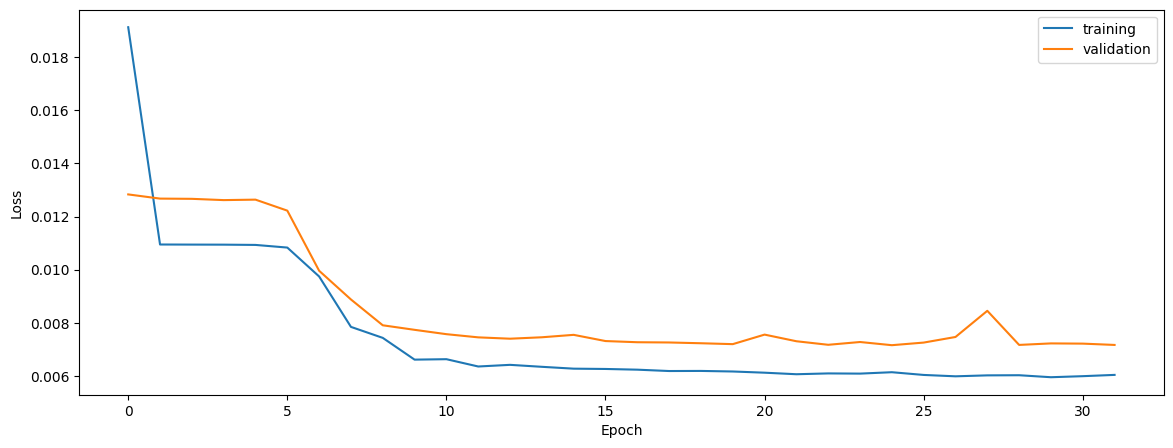

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6732328166949217
0.6548884053461657
0.6126878292908265


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.6477058641849641
0.62698368017199
0.631095744936947


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.6558191316993106
0.6382210173838165
0.6410932972026433


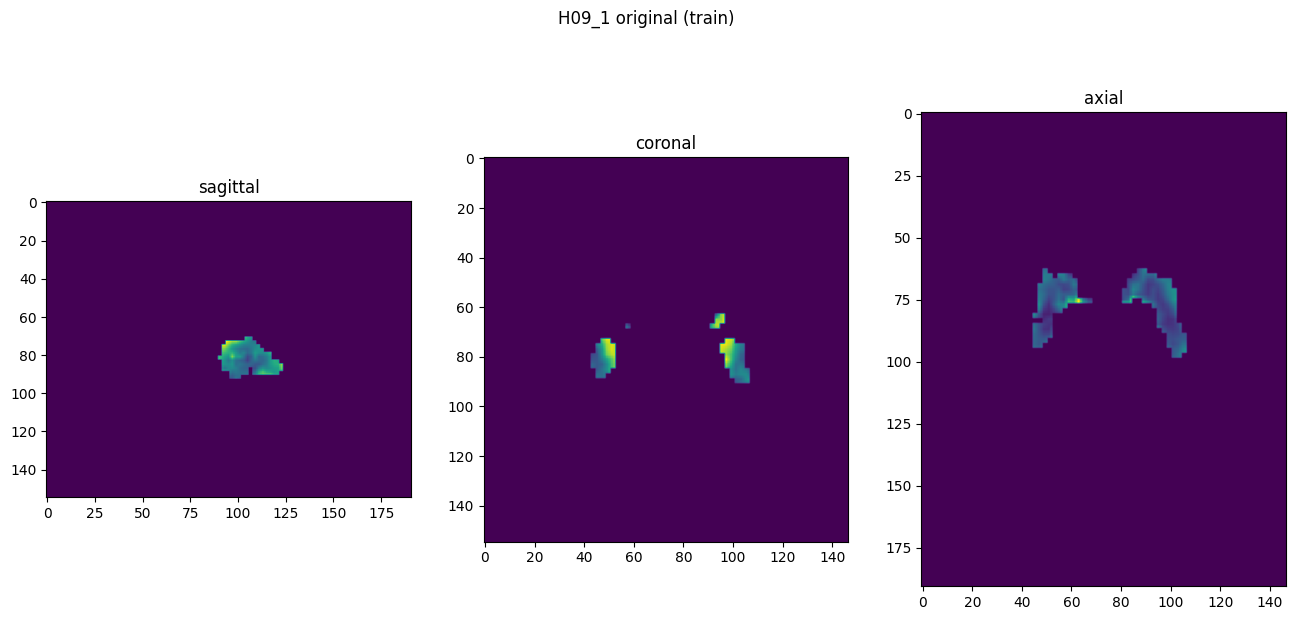

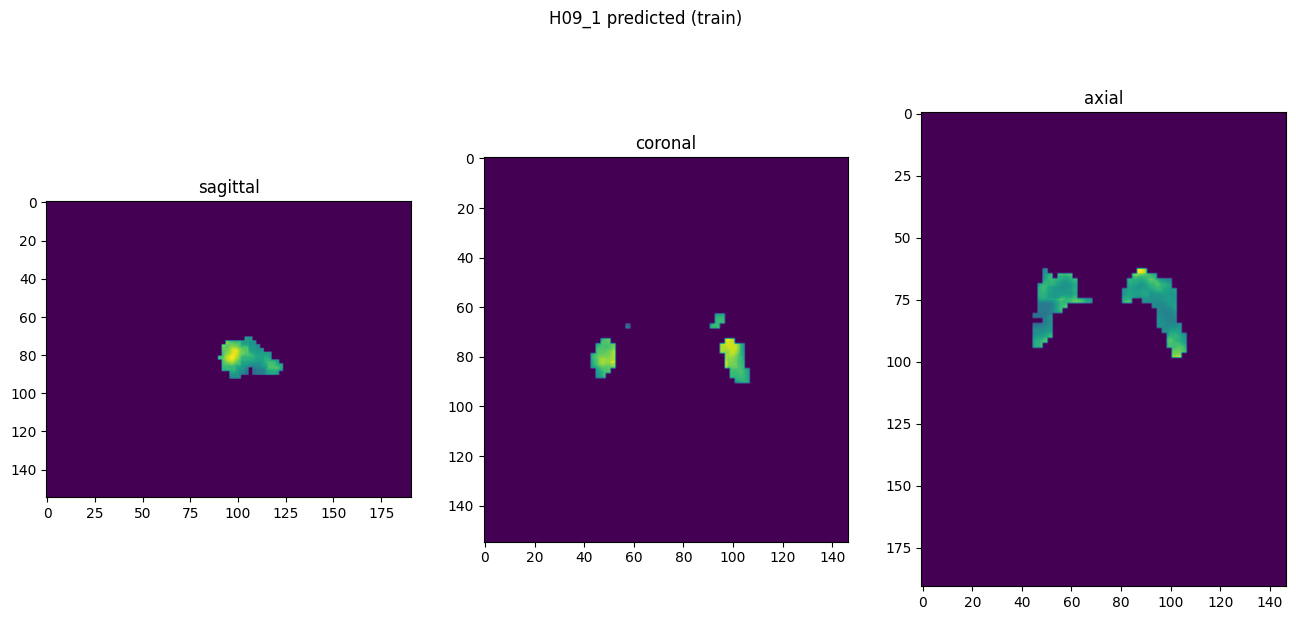

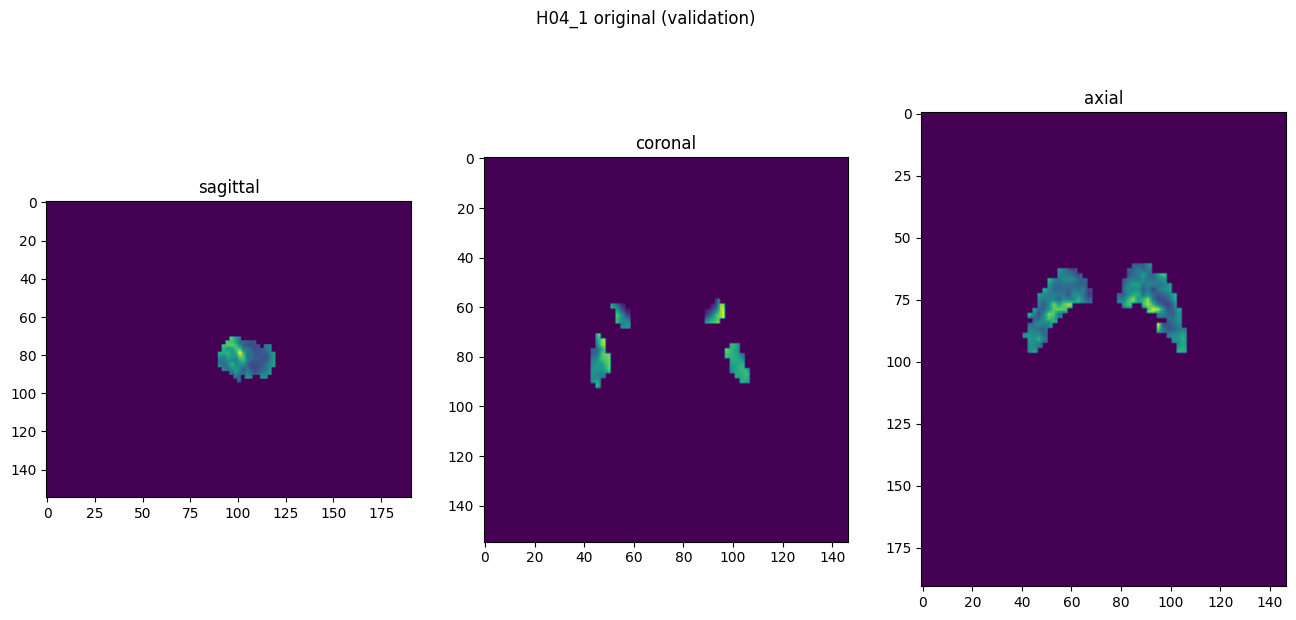

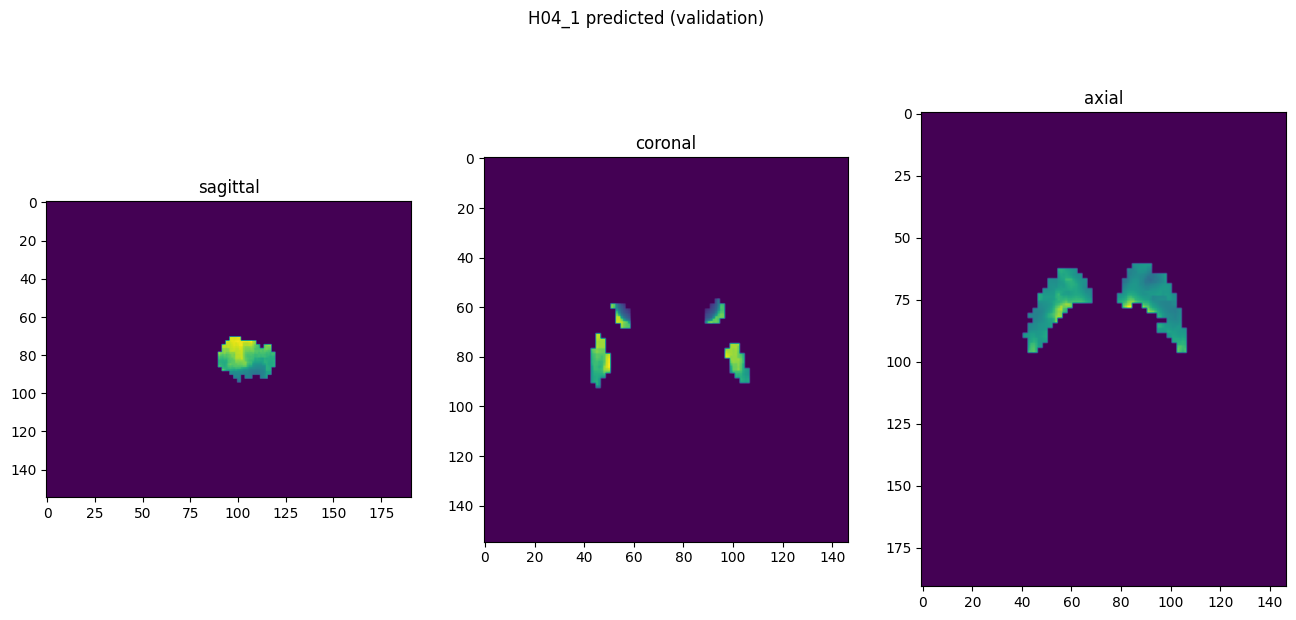

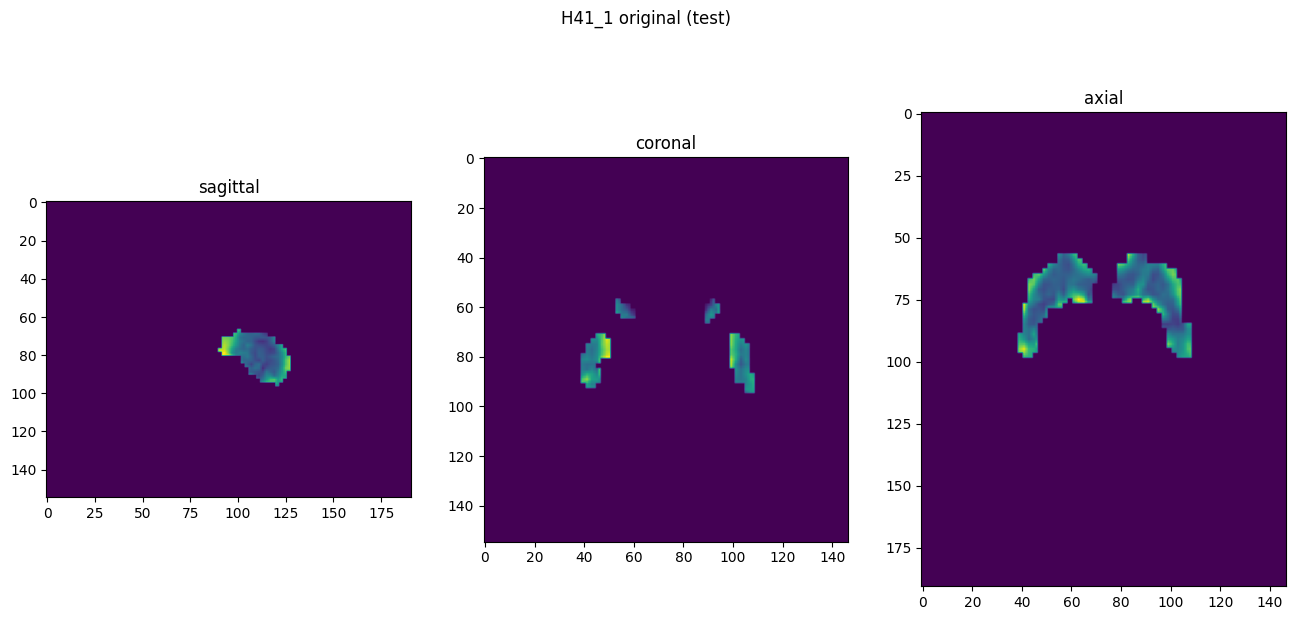

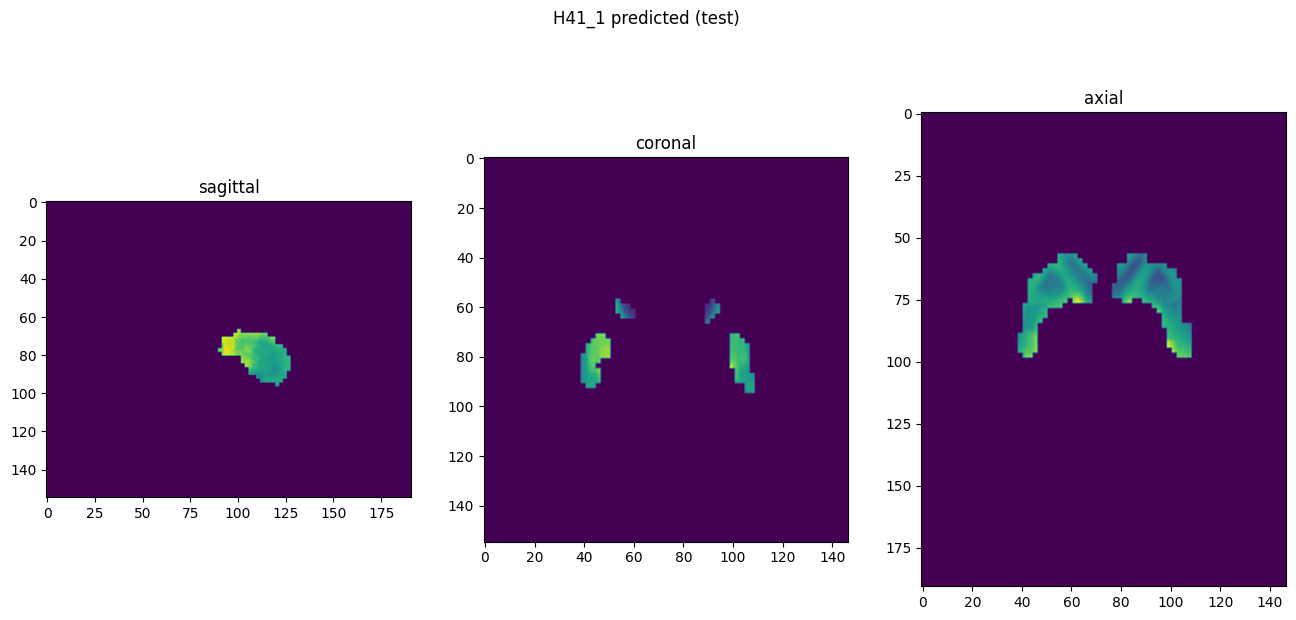

In [10]:
showResults(model, gen, threshold=None, background=False)